In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
# imported libraries

In [23]:
# #clean per-capita-meat-type.csv
# import pandas as pd

# meat_df = pd.read_csv("datasets/original datasets/per-capita-meat-type.csv")
# codes_df = pd.read_csv("datasets/codes.csv")

# merged = pd.merge(meat_df, codes_df, left_on="Code", right_on="alpha-3", how="left")

# filtered = merged[merged["region"].isin(["Asia", "Europe"])]

# latest = filtered.sort_values("Year").groupby("Code").tail(1)

# meat_columns = [col for col in latest.columns if col.startswith("Meat")]
# latest["Total_Meat_kg_per_capita"] = latest[meat_columns].sum(axis=1)

# final_df = latest[["Entity", "Code", "Year", "region", "Total_Meat_kg_per_capita"] + meat_columns]

# final_df.to_csv("asia_europe_meat_consumption.csv", index=False)

# print(final_df["region"].value_counts())


In [24]:
# What we are going to do is use bootstrap sampling on the correlation between meat consumption and michlein star count.
# The rationale here is as such:
# Each COUNTRY has two VALUES. These VALUES are MEAT CONSUMPTION and MICHELIN COUNT (this can be either count of restaurants or count of stars.)
# We divide the two groups of countries into ASIAN and EUROPEAN.

In [25]:
# We merge the 3 datasets together so that we have a single dataframe with the following columns:
# country
# michelin_count 
# region
# Total_Meat_kg_per_capita
# so that we have all required variables in one table which makes permutation, bootstrapping and linear regression easier
import pandas as pd

michelin = pd.read_csv("datasets/michelin.csv")
codes = pd.read_csv("datasets/codes.csv")
meat = pd.read_csv("datasets/asia_europe_meat_consumption.csv")

country_replacements = {
    "Schweiz": "Switzerland",
    "Suisse": "Switzerland",
    "Svizzera": "Switzerland",
    "South Korea": "Korea, Republic of",
    "Deutschland": "Germany",
    "Taipei & Taichung": "Taiwan, Province of China",
    "United States": "United States of America",
    "United Kingdom": "United Kingdom of Great Britain and Northern Ireland",
    "Macau": "Macao",
    "China Mainland": "China",
    "Nederland": "Netherlands, Kingdom of the",
    "Россия": "Russian Federation"
}
michelin['country'] = michelin['country'].replace(country_replacements)
filtered_michelin = michelin[michelin['country'].isin(codes['name'])]
european_countries = codes[codes['region'] == 'Europe']['name']
asian_countries = codes[codes['region'] == 'Asia']['name']
filtered_michelin = filtered_michelin[
    filtered_michelin['country'].isin(european_countries) |
    filtered_michelin['country'].isin(asian_countries)
]
michelin_counts = (
    filtered_michelin.groupby('country')
    .size()
    .reset_index(name='michelin_count')
)
michelin_with_region = michelin_counts.merge(
    codes[['name', 'region']],
    left_on='country',
    right_on='name',
    how='left'
).drop(columns=['name'])
meat['Entity'] = meat['Entity'].replace(country_replacements)

meat_clean = meat[['Entity', 'Total_Meat_kg_per_capita']]

merged_df = michelin_with_region.merge(
    meat_clean,
    left_on='country',
    right_on='Entity',
    how='inner'
).drop(columns=['Entity'])

print(merged_df.head())
merged_df.to_csv("merged_data.csv", index=False)
#print how many total countrys there are by region
print("Total countries in Europe:", merged_df[merged_df['region'] == 'Europe'].shape[0])
print("Total countries in Asia:", merged_df[merged_df['region'] == 'Asia'].shape[0])


   country  michelin_count  region  Total_Meat_kg_per_capita
0  Austria              18  Europe                 76.884831
1  Belgium             125  Europe                 64.558488
2    China             107    Asia                 70.004751
3  Croatia              10  Europe                 97.143633
4  Denmark              27  Europe                 66.796232
Total countries in Europe: 22
Total countries in Asia: 6


       Total_Meat_kg_per_capita                                              \
                          count       mean        std        min        25%   
region                                                                        
Asia                        6.0  79.115165  35.639996  25.916176  62.437039   
Europe                     22.0  78.583137  11.966987  60.563023  69.030241   

                                          michelin_count              \
              50%         75%         max          count        mean   
region                                                                 
Asia    76.729219  104.617354  123.729998            6.0  110.500000   
Europe  77.798357   85.177112  104.159300           22.0   95.909091   

                                                     
               std   min   25%   50%     75%    max  
region                                               
Asia    148.551338  15.0  32.0  51.5   98.00  406.0  
Europe  157.659038   1.0   

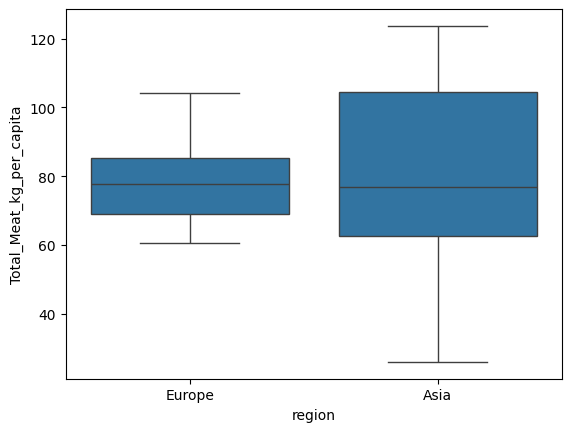

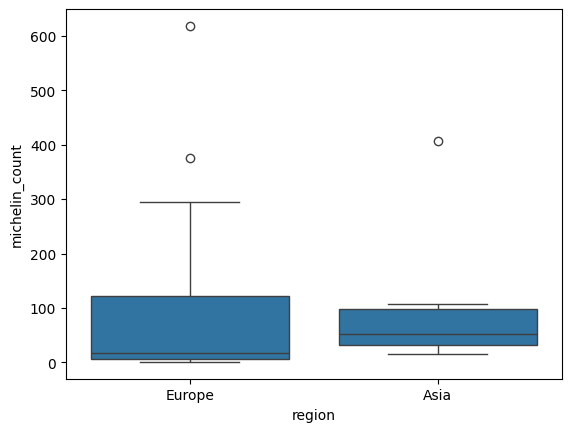

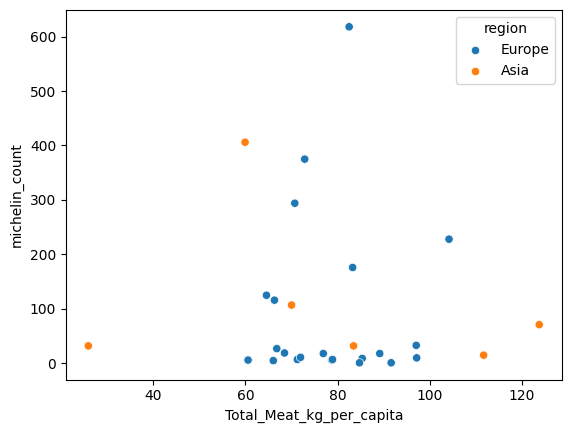

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load merged data
df = pd.read_csv("merged_data.csv")

# Summary statistics
print(df.groupby("region")[["Total_Meat_kg_per_capita", "michelin_count"]].describe())

# Boxplots
sns.boxplot(x="region", y="Total_Meat_kg_per_capita", data=df)
plt.show()

sns.boxplot(x="region", y="michelin_count", data=df)
plt.show()

# Scatterplot
sns.scatterplot(
    data=df,
    x="Total_Meat_kg_per_capita",
    y="michelin_count",
    hue="region"
)
plt.show()


region
Europe    22
Asia       6
Name: count, dtype: int64


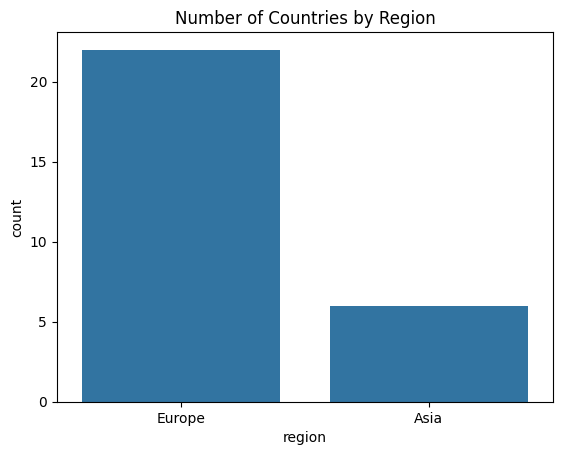

       Total_Meat_kg_per_capita                                              \
                          count       mean        std        min        25%   
region                                                                        
Asia                        6.0  79.115165  35.639996  25.916176  62.437039   
Europe                     22.0  78.583137  11.966987  60.563023  69.030241   

                                          michelin_count              \
              50%         75%         max          count        mean   
region                                                                 
Asia    76.729219  104.617354  123.729998            6.0  110.500000   
Europe  77.798357   85.177112  104.159300           22.0   95.909091   

                                                     
               std   min   25%   50%     75%    max  
region                                               
Asia    148.551338  15.0  32.0  51.5   98.00  406.0  
Europe  157.659038   1.0   

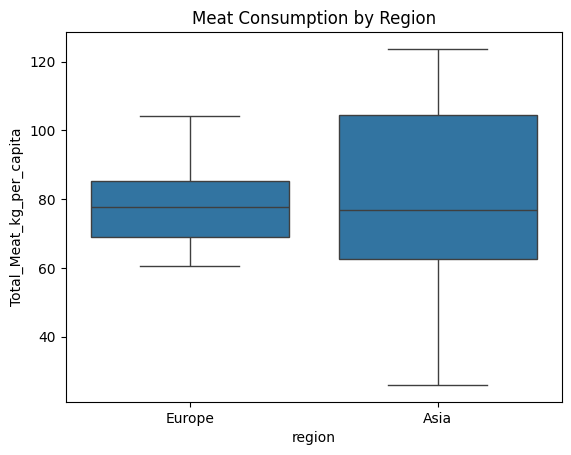

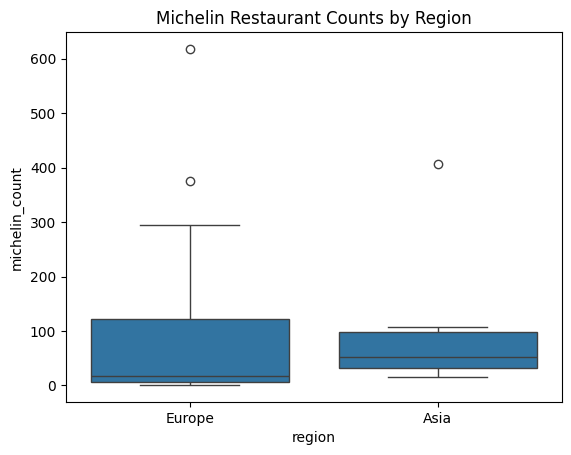

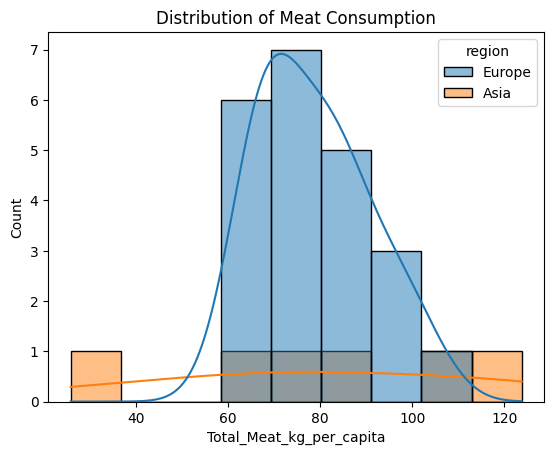

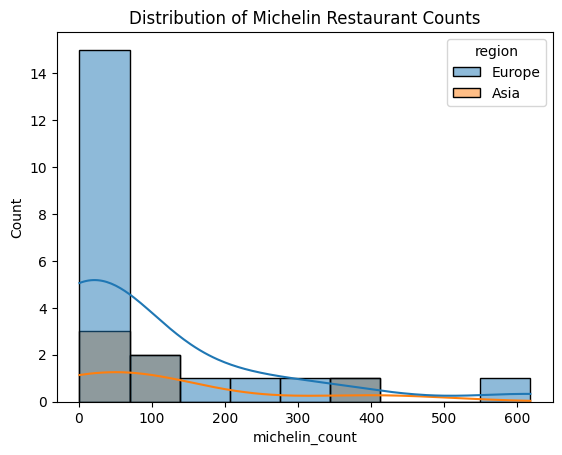

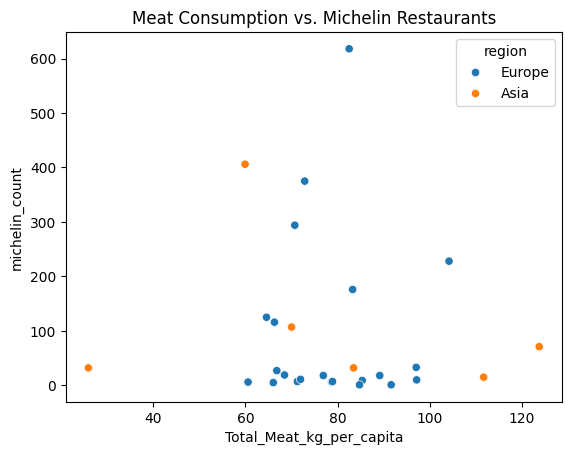

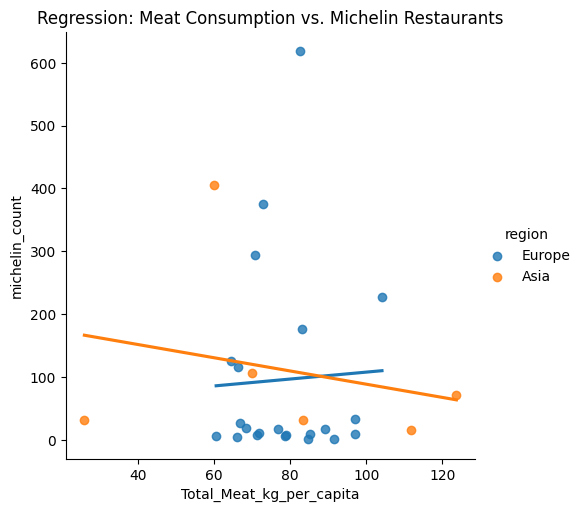

   country  michelin_count  region  Total_Meat_kg_per_capita
6   France             618  Europe                 82.492909
14   Japan             406    Asia                 59.914468
     country  michelin_count region  Total_Meat_kg_per_capita
9  Hong Kong              71   Asia                123.729998


In [27]:
df = pd.read_csv("datasets/merged_data.csv")

#  countries in each region
region_counts = df['region'].value_counts()
print(region_counts)

#  country count by region
sns.countplot(x='region', data=df)
plt.title("Number of Countries by Region")
plt.show()

summary_stats = df.groupby("region")[["Total_Meat_kg_per_capita", "michelin_count"]].describe()
print(summary_stats)

# meat by region
sns.boxplot(x="region", y="Total_Meat_kg_per_capita", data=df)
plt.title("Meat Consumption by Region")
plt.show()

#  michelin by region
sns.boxplot(x="region", y="michelin_count", data=df)
plt.title("Michelin Restaurant Counts by Region")
plt.show()


# hist for meat consumption
sns.histplot(data=df, x="Total_Meat_kg_per_capita", hue="region", kde=True)
plt.title("Distribution of Meat Consumption")
plt.show()

# hist for no of muichrlin
sns.histplot(data=df, x="michelin_count", hue="region", kde=True)
plt.title("Distribution of Michelin Restaurant Counts")
plt.show()

sns.scatterplot(
    data=df,
    x="Total_Meat_kg_per_capita",
    y="michelin_count",
    hue="region"
)
plt.title("Meat Consumption vs. Michelin Restaurants")
plt.show()

sns.lmplot(
    data=df,
    x="Total_Meat_kg_per_capita",
    y="michelin_count",
    hue="region",
    ci=None
)
plt.title("Regression: Meat Consumption vs. Michelin Restaurants")
plt.show()

# countries with peak michelin restaurants
print(df[df['michelin_count'] > df['michelin_count'].mean() + 2*df['michelin_count'].std()])

# countries with high meat consumption
print(df[df['Total_Meat_kg_per_capita'] > df['Total_Meat_kg_per_capita'].mean() + 2*df['Total_Meat_kg_per_capita'].std()])


# Why our research is relevant
---
There is always the debate in diet of meats versus vegetables, and we want to find out if they really are mutually exclusive. We also want to analyse the trends in meat and vegetable consumption over the years, and how they play off of each other.

In [28]:
# Import relevant datasets

df_meats = pd.read_csv('datasets/per-capita-meat-type.csv')
df_vegs = pd.read_csv('datasets/vegetable-consumption-per-capita.csv')

# Replace long column names with ones that are more easy to access
df_meats = df_meats.rename(columns={
    'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita': 'Poultry',
    'Meat, beef and buffalo | 00002731 || Food available for consumption | 0645pc || kilograms per year per capita': 'BeefBuffalo',
    'Meat, sheep and goat | 00002732 || Food available for consumption | 0645pc || kilograms per year per capita': 'SheepGoat',
    'Meat, pig | 00002733 || Food available for consumption | 0645pc || kilograms per year per capita': 'Pig',
    'Meat, Other | 00002735 || Food available for consumption | 0645pc || kilograms per year per capita': 'OtherMeat',
    'Fish and seafood | 00002960 || Food available for consumption | 0645pc || kilograms per year per capita': 'Seafood'
})

# Find total consumption
df_meats['totalconsumption'] = df_meats[['Poultry', 'BeefBuffalo', 'SheepGoat', 'Pig', 'OtherMeat', 'Seafood']].sum(axis=1, skipna=True)

df_vegs = df_vegs.rename(columns={
    'Vegetables | 00002918 || Food available for consumption | 0645pc || kilograms per year per capita': 'Vegetables'
})

# Compensate for muslim countries which may not have info for pigs.
df_meats['Pig'] = df_meats['Pig'].fillna(0)

print(df_meats.head())
print(df_vegs.head())

        Entity Code  Year   Poultry  BeefBuffalo  SheepGoat  Pig  OtherMeat  \
0  Afghanistan  AFG  1961  0.612220     4.664536   7.949147  0.0   0.826012   
1  Afghanistan  AFG  1962  0.641587     4.870231   7.699047  0.0   0.855450   
2  Afghanistan  AFG  1963  0.641828     4.920679   7.867252  0.0   1.040539   
3  Afghanistan  AFG  1964  0.651754     4.893021   8.122609  0.0   0.982495   
4  Afghanistan  AFG  1965  0.681102     4.855283   8.406744  0.0   1.031383   

    Seafood  totalconsumption  
0  0.029153         14.081069  
1  0.029163         14.095478  
2  0.029174         14.499472  
3  0.029183         14.679062  
4  0.029190         15.003702  
        Entity Code  Year  Vegetables
0  Afghanistan  AFG  1961   35.712856
1  Afghanistan  AFG  1962   36.424660
2  Afghanistan  AFG  1963   37.799760
3  Afghanistan  AFG  1964   39.076070
4  Afghanistan  AFG  1965   39.727703


In [51]:
# EDA
# What is the data we will need to be able to effectively answer the Q?
# Filter by current data. Get some summary statistics.
# Get histogram of meat and veg in 2022/2024.
# Get ECDF of meat and veg in 2022/2024.

# --------------------------------- Histogram -------------------------------- #
# For meat
# For all countries, so we should filter by entries that have a code.

# Calculate total meat

# Keep only rows for year 2022
meat_2022 = df_meats[df_meats['Year'] == 2022]

# Create a code filter for european countries
eu_codes = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA',
    'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE',
    'ALB', 'AND', 'ARM', 'BLR', 'BIH', 'FRO', 'GEO', 'GIB', 'ISL', 'IMN', 'XKX', 'LIE', 'MKD', 'MDA', 'MCO',
    'MNE', 'NOR', 'RUS', 'SMR', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'VAT'
]


# Create a code filter for asian countries
ap_codes = [
    'AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'IOT', 'BRN',
    'KHM', 'CHN', 'CCK', 'GEO', 'HKG', 'IND', 'IDN', 'IRN',
    'IRQ', 'ISR', 'JPN', 'JOR', 'KAZ', 'KWT', 'KGZ', 'LAO',
    'LBN', 'MAC', 'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'PRK',
    'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU', 'SGP', 'KOR',
    'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TUR', 'TKM', 'ARE',
    'UZB', 'VNM', 'YEM'
]

# Filter
meat_2022_eu = meat_2022[meat_2022['Code'].isin(eu_codes)]
meat_2022_ap = meat_2022[meat_2022['Code'].isin(ap_codes)]

# Do the same for vegetables
veg_2022 = df_vegs[df_vegs['Year'] == 2022]

veg_2022_eu = veg_2022[veg_2022['Code'].isin(eu_codes)]
veg_2022_ap = veg_2022[veg_2022['Code'].isin(ap_codes)]

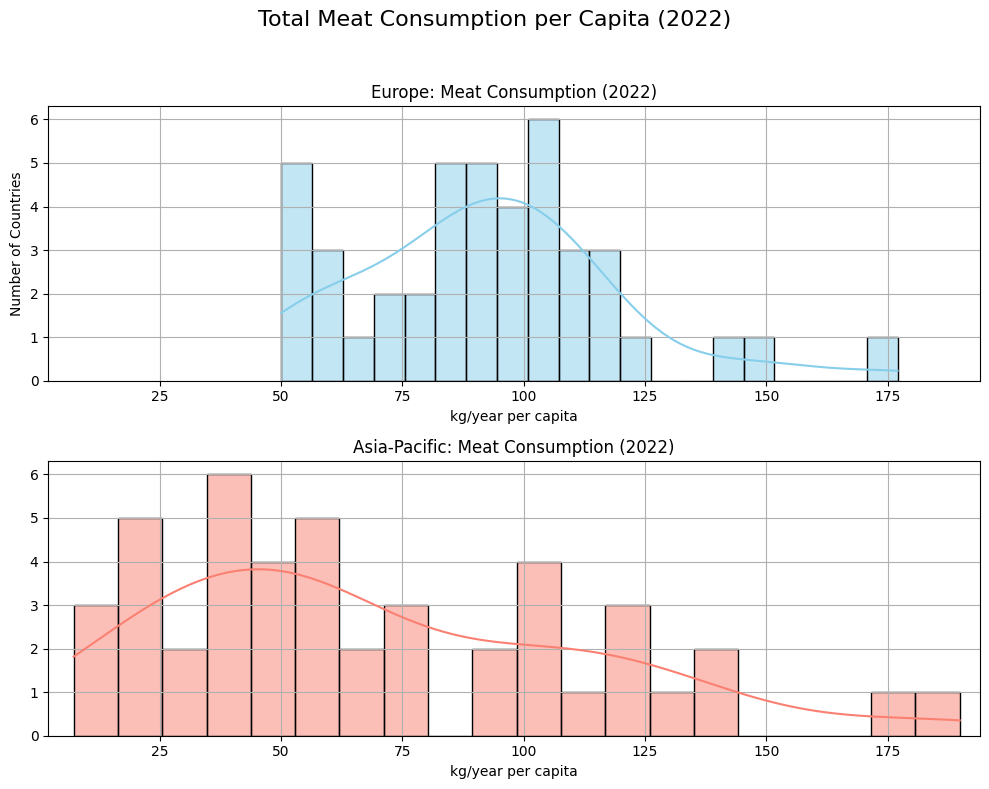

In [52]:
# Make a histogram of the total consumptions
# Display them onto the same axes

# Get combined min and max for x-axis
min_x = min(meat_2022_eu['totalconsumption'].min(), meat_2022_ap['totalconsumption'].min())
max_x = max(meat_2022_eu['totalconsumption'].max(), meat_2022_ap['totalconsumption'].max())

# Optional: round slightly outward for padding
xlim = (int(min_x) - 5, int(max_x) + 5)

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# Europe histogram
sns.histplot(meat_2022_eu['totalconsumption'], color='skyblue', kde=True, bins=20, ax=axs[0])
axs[0].set_title('Europe: Meat Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(meat_2022_ap['totalconsumption'], color='salmon', kde=True, bins=20, ax=axs[1])
axs[1].set_title('Asia-Pacific: Meat Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim)
axs[1].grid(True)

# Final layout
fig.suptitle('Total Meat Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

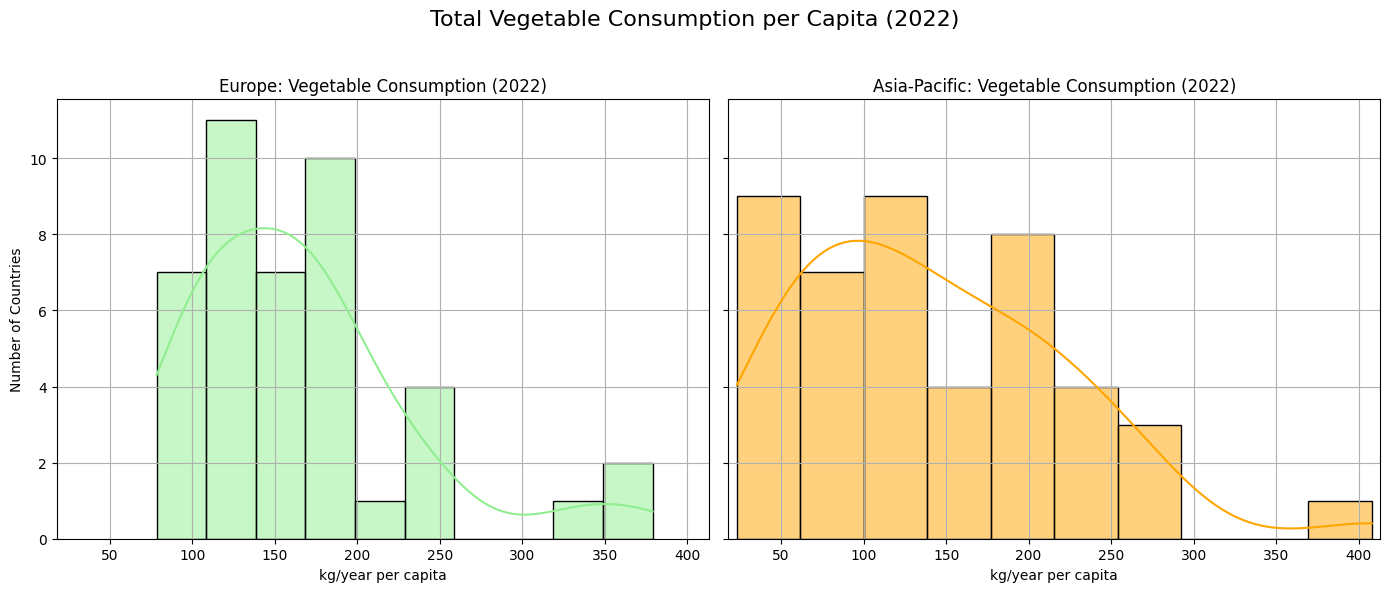

In [53]:
# Get shared x-axis limits
min_x = min(veg_2022_eu['Vegetables'].min(), veg_2022_ap['Vegetables'].min())
max_x = max(veg_2022_eu['Vegetables'].max(), veg_2022_ap['Vegetables'].max())
xlim = (int(min_x) - 5, int(max_x) + 5)

# Set up side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Europe histogram
sns.histplot(veg_2022_eu['Vegetables'], color='lightgreen', kde=True, bins=10, ax=axs[0])
axs[0].set_title('Europe: Vegetable Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(veg_2022_ap['Vegetables'], color='orange', kde=True, bins=10, ax=axs[1])
axs[1].set_title('Asia-Pacific: Vegetable Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim)
axs[1].grid(True)

# Final layout tweaks
fig.suptitle('Total Vegetable Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()